# Multi-dataset training and filtering
The key feature of `StandardE2E` is unified API for end-to-end self-driving datasets processing. Naturally it allows for consistently utilizing data from multiple datasets, eg. seamlessly training on a few. In this example we will cover training on both `Waymo End-to-End` and `Waymo Perceprion` datasets.

First, we need both datasets to be preprocessed. This can be done with, for example, [prepare_datasets_waymo_e2e_perception.sh](../scripts/prepare_datasets_waymo_e2e_perception.sh). Also, we cover the idea of preprocessing in our [intro_tutorial.ipynb](intro_tutorial.ipynb). Once you finish you should have `waymo_e2e` and `waymo_perception` folders in your output directory like
```text
    output_directory/
    ├─ waymo_e2e/
    │  ├─ training/
    │  │  ├─ *.npz
    │  │  └─ index.parquet
    │  └─ val/
    │     ├─ *.npz
    │     └─ index.parquet
    └─ waymo_perception/
       ├─ training/
       │  ├─ *.npz
       │  └─ index.parquet
       └─ validation/
          ├─ *.npz
          └─ index.parquet
```

Let's start by loading index files

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

from standard_e2e import UnifiedE2EDataset
from standard_e2e.dataset_utils.augmentation import (
    MultipleFramesImageAugmentation,
    TrajectoryResampling
)
from standard_e2e.dataset_utils.modality_defaults import (
    ModalityDefaults,
    PreferredTrajectoryDefaults,
    IntentDefaults,
)
from standard_e2e.enums import Modality, TrajectoryComponent
from standard_e2e.indexing.filters import FrameFilterByBooleanColumn, IndexFilter
from standard_e2e.indexing import get_multi_dataset_index
from standard_e2e.dataset_utils.frame_loader import (
    FrameLoader,
)
from standard_e2e.dataset_utils.selector import (
    ClosestTimestampSelector,
    CurrentSelector,
)

processed_data_path = "/path/to/cache/standard_e2e"

def get_unified_index(regime: str) -> pd.DataFrame:
    waymo_e2e_index = pd.read_parquet(
        os.path.join(processed_data_path, "waymo_e2e", regime, "index.parquet")
    )
    # Map "val" to "validation" for waymo_perception
    if regime == "val":
        regime = "validation"
    waymo_perception_index = pd.read_parquet(
        os.path.join(processed_data_path, "waymo_perception", regime, "index.parquet")
    )
    unified_index = get_multi_dataset_index(
        [waymo_e2e_index, waymo_perception_index]
    )
    print(f"Waymo End-to-end {regime} dataset size:", waymo_e2e_index.shape[0])
    print(f"Waymo Perception {regime} dataset size:", waymo_perception_index.shape[0])
    print(f"Unified {regime} dataset size:", unified_index.shape[0])
    assert unified_index.shape[0] == (
        waymo_e2e_index.shape[0] + waymo_perception_index.shape[0]
    )
    return unified_index, waymo_e2e_index, waymo_perception_index

unified_train_index, waymo_e2e_train_index, waymo_perception_train_index = get_unified_index("training")
unified_val_index, waymo_e2e_val_index, waymo_perception_val_index = get_unified_index("val")

Waymo End-to-end training dataset size: 415663
Waymo Perception training dataset size: 158081
Unified training dataset size: 573744
Waymo End-to-end validation dataset size: 106360
Waymo Perception validation dataset size: 39987
Unified validation dataset size: 146347


Then we create loaders, which were mainly covered in [intro_tutorial.ipynb](intro_tutorial.ipynb). Here we only emphasize that we want to use `Modality.INTENT` as a feature which is only present in `Waymo E2E` dataset and also evaluate model's predictions against `Modality.PREFERENCE_TRAJECTORY` which is only availabe for a subset of frames in `Waymo E2E` only.

In [2]:
# Example filtering: Count samples with available preference trajectories in validation set
unified_val_index[unified_val_index['extra_has_preference_trajectories'] == True].shape[0]

479

In [3]:
feature_loaders = [
    FrameLoader(
        frame_name="current_sensors",
        required_modalities=[
            Modality.CAMERAS,
            Modality.INTENT,
        ],
        frame_selector=CurrentSelector(location="features"),
    )
]
label_loaders = [
    FrameLoader(
        frame_name="current_future_states",
        required_modalities=[
            Modality.FUTURE_STATES,
            Modality.PREFERENCE_TRAJECTORY,
        ],
        frame_selector=CurrentSelector(location="labels"),
    )
]

Our training setup would be the following: we use the current camera image and intent as features. Since there is no intent for perception dataset, we will fill in the default value for it with `ModalityDefaults`.

During training we will evaluate the model for 2 cases: measuring its predictions against future trajectory and also measuring the quality for predicting preference trajectory, which are only available for a subset of val in `WaymoE2E` dataset. We handle filtering with `IndexFilter`.

In [4]:
def create_dataloader(
    feature_loaders: list[FrameLoader],
    label_loaders: list[FrameLoader],
    processed_data_path: str,
    index_df: pd.DataFrame,
    regime: str,
    batch_size: int = 64,
    num_workers: int = 32,
    index_filters: list[IndexFilter] | None = None,
    modality_defaults: dict[Modality, ModalityDefaults] | None = None,
):
    """
    Create a DataLoader for the UnifiedE2EDataset.
    """
    future_time_lattice = np.linspace(0, 10, 21)[1:]
    dataset = UnifiedE2EDataset(
        processed_data_path=processed_data_path,
        feature_loaders=feature_loaders,
        label_loaders=label_loaders,
        index_data=index_df,
        regime=regime,
        augmentations=[
            MultipleFramesImageAugmentation(regime),
            TrajectoryResampling(
                future_target_timestamps=future_time_lattice,
                target_frame_names=["current_future_states"],
            ),
        ],
        index_filters=index_filters,
        modality_defaults=modality_defaults,
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=regime == "train",
        collate_fn=dataset.collate_fn,
        num_workers=num_workers,
    )
    return dataloader

Here we use `TrajectoryResampling` in augmentations to introduce a unified time lattice for both datasets. Namely, `Waymo E2E` dataset has $\Delta t_{traj} = 0.25 s$ for trajectory states (not to be mismatched with $\Delta t_{frame} = 0.1 s$ between frames) whereas `Waymo Perception` dataset has $\Delta t_{traj} = 0.1 s$ and may also have different number of trajectory states available. Another way could be passing $t_{state}$ directly to the model, where $t_{state} = 0$ denotes the current frame, $t_{state} > 0$ and $t_{state} < 0$ refer to the future and the past correspondingly. See more about trajectory resampling [here](./containers.ipynb)

In [5]:
train_dataloader = create_dataloader(
    feature_loaders=feature_loaders,
    label_loaders=label_loaders,
    processed_data_path=processed_data_path,
    index_df=unified_train_index,
    regime="train",
    modality_defaults={
        Modality.PREFERENCE_TRAJECTORY: PreferredTrajectoryDefaults(),
        Modality.INTENT: IntentDefaults(),
    },
)
val_dataloader = create_dataloader(
    feature_loaders=feature_loaders,
    label_loaders=label_loaders,
    processed_data_path=processed_data_path,
    index_df=unified_val_index,
    regime="val",
    modality_defaults={
        Modality.PREFERENCE_TRAJECTORY: PreferredTrajectoryDefaults(),
        Modality.INTENT: IntentDefaults(),
    },
)

filter_only_with_preference_trajectory = FrameFilterByBooleanColumn(
    boolean_column="extra_has_preference_trajectories"
)
val_dataloader_with_filter = create_dataloader(
    feature_loaders=feature_loaders,
    label_loaders=label_loaders,
    processed_data_path=processed_data_path,
    index_df=unified_val_index,
    regime="val",
    index_filters=[filter_only_with_preference_trajectory],
)

/home/stvn/code/StandardE2E/standard_e2e/indexing/filters/frame_boolean_filter.py:42: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  selector = selector.fillna(False)


In [6]:
class VerySimpleE2EModel(nn.Module):
    """A very simple end-to-end model for demonstration purposes."""

    def __init__(self, out_dim: int = 40):
        super(VerySimpleE2EModel, self).__init__()
        self._cnn_backbone = torch.hub.load(
            "pytorch/vision:v0.10.0", "resnet18", pretrained=True
        )
        self._cnn_backbone.fc = nn.Identity()
        self._out_dim = out_dim
        self._fusion_layer = nn.Sequential(
            nn.BatchNorm1d(516),
            nn.ReLU(),
            nn.Linear(516, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, out_dim),
        )

    def forward(
        self, image: torch.Tensor, intent: torch.Tensor
    ) -> torch.Tensor:
        bs = image.size(0)
        image_embedding = self._cnn_backbone(image)
        intent_ohe = torch.nn.functional.one_hot(intent.long(), num_classes=4).float()
        x = torch.cat([image_embedding, intent_ohe], dim=1)
        x = self._fusion_layer(x)
        x = x.view(bs, -1, 2)
        return x


class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(
        self, output: torch.Tensor, target: torch.Tensor, mask: torch.Tensor
    ) -> torch.Tensor:
        loss = torch.nn.functional.mse_loss(output, target, reduction="none")
        loss = loss * mask
        return loss.mean()


In [7]:
XY_COMPONENTS = [TrajectoryComponent.X, TrajectoryComponent.Y]

def visualize(outputs, batch, epoch=None):
    from matplotlib import pyplot as plt

    valid_future_states = batch["current_future_states"] \
        .get_modality_data(Modality.FUTURE_STATES) \
        .get(XY_COMPONENTS)[0] \
        .cpu() \
        .numpy()
    valid_future_states = valid_future_states[
        batch["current_future_states"]
        .get_modality_data(Modality.FUTURE_STATES)
        .get(TrajectoryComponent.IS_VALID)[0]
        .cpu()
        .numpy().astype(bool).flatten()
    ]
    for preference_trajectory in batch["current_future_states"] \
        .get_modality_data(Modality.PREFERENCE_TRAJECTORY):
        valid_preference_trajectory = preference_trajectory \
            .get(XY_COMPONENTS)[0] \
            .cpu() \
            .numpy()
        valid_preference_trajectory = valid_preference_trajectory[
            preference_trajectory
            .get(TrajectoryComponent.IS_VALID)[0]
            .cpu()
            .numpy().astype(bool).flatten()
        ]
        plt.plot(
            *valid_preference_trajectory.T, '-o',
            label=f'Preference Trajectory: score={preference_trajectory.scores[0].item():.2f}')
    plt.plot(*valid_future_states.T, '-o', label='Ground Truth Future Trajectory')
    plt.plot(*outputs[0].cpu().detach().numpy().T, '-o', label='Predicted Trajectory')
    plt.axis('equal')
    plt.grid()
    plt.legend()
    plt.title(f'Epoch {epoch}' if epoch is not None else 'Trajectory Visualization')
    plt.show()

Using cache found in /home/stvn/.cache/torch/hub/pytorch_vision_v0.10.0
Filtered Validation Epoch 1: 100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


Epoch 1 - Train Loss: 40.0326, Val Loss: 62.0687, Preferred Trajectory Loss: 30.0762


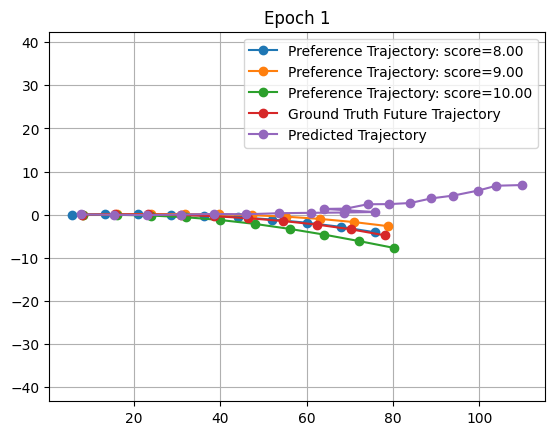

Filtered Validation Epoch 2: 100%|██████████| 8/8 [00:03<00:00,  2.53it/s]


Epoch 2 - Train Loss: 9.5276, Val Loss: 61.9888, Preferred Trajectory Loss: 31.5771


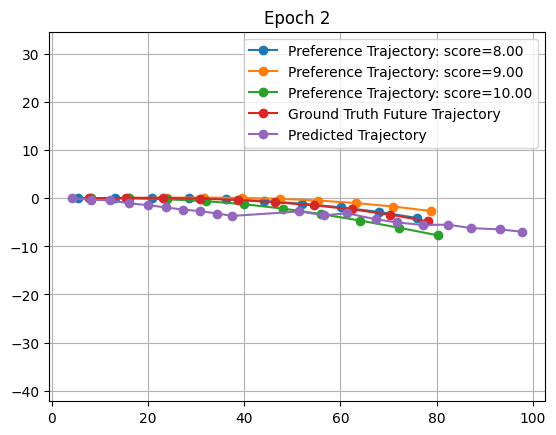

Filtered Validation Epoch 3: 100%|██████████| 8/8 [00:03<00:00,  2.57it/s]


Epoch 3 - Train Loss: 5.5571, Val Loss: 55.0784, Preferred Trajectory Loss: 27.3523


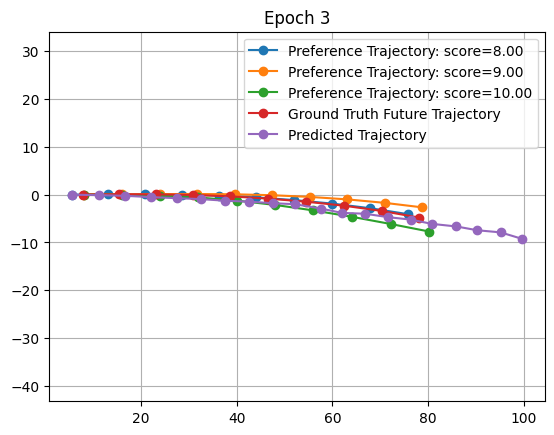

Filtered Validation Epoch 4: 100%|██████████| 8/8 [00:03<00:00,  2.63it/s]


Epoch 4 - Train Loss: 4.0067, Val Loss: 55.4147, Preferred Trajectory Loss: 32.1203


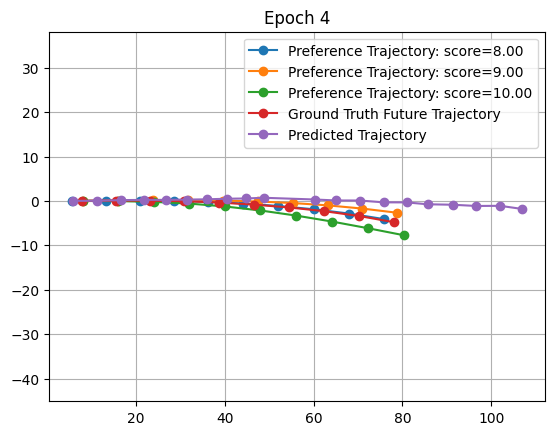

Filtered Validation Epoch 5: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


Epoch 5 - Train Loss: 3.4208, Val Loss: 54.8213, Preferred Trajectory Loss: 33.0802


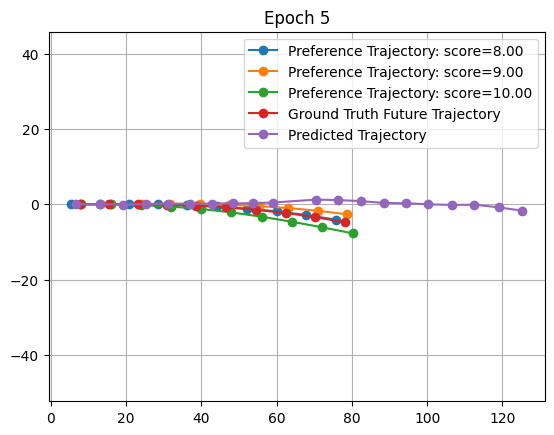

In [8]:
model = VerySimpleE2EModel()
model.cuda()
optimizer = Adam(model.parameters(), lr=0.0003)
masked_criterion = MaskedMSELoss()

for epoch in range(5):
    train_loss = []
    val_loss = []
    preferred_trajectory_loss = []
    model.train()
    pbar = tqdm(
        train_dataloader,
        total=len(train_dataloader),
        desc=f"Training Epoch {epoch + 1}",
    )
    for batch in pbar:
        batch["current_sensors"] = batch["current_sensors"].cuda()
        optimizer.zero_grad()
        outputs = model(
            batch["current_sensors"].get_modality_data(Modality.CAMERAS),
            batch["current_sensors"].get_modality_data(Modality.INTENT)
        )
        loss = masked_criterion(
            outputs,
            batch["current_future_states"]
                .get_modality_data(Modality.FUTURE_STATES)
                .get(XY_COMPONENTS)
                .cuda(),
            batch["current_future_states"]
                .get_modality_data(Modality.FUTURE_STATES)
                .get(TrajectoryComponent.IS_VALID)
                .cuda(),
        )
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        pbar.set_description(
            f"Training Epoch {epoch + 1}, loss: {np.mean(train_loss[-100:]):.4f}"
        )

    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}"):
            batch["current_sensors"] = batch["current_sensors"].cuda()
            outputs = model(
                batch["current_sensors"].get_modality_data(Modality.CAMERAS),
                batch["current_sensors"].get_modality_data(Modality.INTENT)
            )
            loss = masked_criterion(
                outputs,
                batch["current_future_states"]
                    .get_modality_data(Modality.FUTURE_STATES)
                    .get(XY_COMPONENTS)
                    .cuda(),
                batch["current_future_states"]
                    .get_modality_data(Modality.FUTURE_STATES)
                    .get(TrajectoryComponent.IS_VALID)
                    .cuda(),
            )
            val_loss.append(loss.item())
        for batch in tqdm(
            val_dataloader_with_filter,
            desc=f"Filtered Validation Epoch {epoch + 1}",
        ):
            batch["current_sensors"] = batch["current_sensors"].cuda()
            outputs = model(
                batch["current_sensors"].get_modality_data(Modality.CAMERAS),
                batch["current_sensors"].get_modality_data(Modality.INTENT)
            )
            loss = masked_criterion(
                outputs,
                batch["current_future_states"]
                    .get_modality_data(Modality.PREFERENCE_TRAJECTORY)[0]
                    .get(XY_COMPONENTS)
                    .cuda(),
                batch["current_future_states"]
                    .get_modality_data(Modality.PREFERENCE_TRAJECTORY)[0]
                    .get(TrajectoryComponent.IS_VALID)
                    .cuda(),
            )
            preferred_trajectory_loss.append(loss.item())
    print(
        f"Epoch {epoch + 1} - Train Loss: {np.mean(train_loss):.4f}, "
        f"Val Loss: {np.mean(val_loss):.4f}, "
        f"Preferred Trajectory Loss: {np.mean(preferred_trajectory_loss):.4f}"
    )
    visualize(outputs, batch, epoch + 1)